In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tqdm

def initial_spins(L): #creates a randon LxL lattice of spins
    return np.random.choice([1, -1], size=(L,L))

def calculate_energy(spins, J, J2, h, L): #calculates the energy of the lattice using nearest neighbor interactions
    energy = 0
    for i in range(L):
        for j in range(L):
            energy -= h*spins[i, j]
            energy -= J*(spins[(i+1)%L, j] + spins[i, (j+1)%L])*spins[i,j]
            energy -= J2*(spins[(i+1)%L, (j+1)%L] + spins[(i-1)%L, (j+1)%L])*spins[i,j]
    return energy

def metropolis_algorithim(spins, beta, J, h, L, J2):
    #making a trial flip
    i, j = np.random.randint(0, L, size=2)
    site = spins[i, j]
    trial_flip = site * -1
    trial_flip_spins = spins.copy()
    trial_flip_spins[i, j] = trial_flip

    #calculating old energy
    old_energy = -h*spins[i, j] - J*(spins[(i+1)%L, j] + spins[i, (j+1)%L]+
                                     spins[(i-1) % L, j] +  spins[i, (j-1)%L])*spins[i, j] - J2*(spins[(i+1)%L, (j+1)%L] + spins[(i-1)%L, (j+1)%L]+
                                     spins[(i-1)%L, (j-1)%L] +  spins[(i+1)%L, (j-1)%L])*spins[i, j]
    #calculating new energy
    new_energy = -h*trial_flip_spins[i, j] - J*(trial_flip_spins[(i+1)%L, j] + trial_flip_spins[i, (j+1)%L]+
                                     trial_flip_spins[(i - 1) % L, j] +  trial_flip_spins[i, (j-1)%L])*trial_flip_spins[i, j]- J2*(trial_flip_spins[(i+1)%L, (j+1)%L] + trial_flip_spins[(i-1)%L, (j+1)%L]+
                                     trial_flip_spins[(i-1)%L, (j-1)%L] +  trial_flip_spins[(i+1)%L, (j-1)%L])*trial_flip_spins[i, j]
    #computing delta E and deciding if we should accept the change
    #new_energy = calculate_energy(trial_flip_spins, J, h, L)
    #old_energy = calculate_energy(spins, J, h, L)

    delta_energy = new_energy - old_energy
    if delta_energy <= 0:
        spins[i, j] = trial_flip
       # print("For delta E = {}, the flip at site [{}, {}] was accepted".format(delta_energy, i, j))
    else:
        w = np.exp(-beta * delta_energy)
        r = random.random()
        if r <= w:
           # print("Random number {}, For delta E = {}".format(r, delta_energy))
            spins[i,j] = trial_flip

    return(spins)

def monte_carlo(beta, J, h, L, steps, spins, J2):
    energies = [calculate_energy(spins, J, J2, h, L)]
    mag_values = [magnetization(spins, L)]
    
    for step in range(steps):
        spins = metropolis_algorithim(spins, beta, J, h, L, J2)
        if step % 100 == 0: #only calculate every 100 steps to try to save some time
            energy = calculate_energy(spins, J, J2, h, L)
            energies.append(energy)

            mag_value = magnetization(spins, L)
            mag_values.append(mag_value)

    return spins, energies, mag_values

def magnetization(spins, L):
    return np.sum(spins)

def specific_heat(energy_value, beta, L): #calculates specific heat for a lattice
    # c = 1/T^2 * (<E^2> - <E>^2)
    average_energy = np.average(energy_value)
    average_energy_squared = np.average(np.square(energy_value))
    return (beta**2) *(average_energy_squared-(average_energy**2))/(L**2)

def heat_capacity(energy_value, beta, L):#calculates heat capcity for a lattice
    #c = 1/T^2 * (<E^2> - <E>^2) * 1/N
    average_energy = np.average(energy_value)
    average_energy_squared = np.average(np.square(energy_value))
    return (beta**2) *(average_energy_squared-(average_energy**2))

def calculate_sus(magnetization_value, beta, L):
    # 1/T (<M^2> - <M>^2)
    M = np.average(np.abs(magnetization_value))
    M_squared = np.average(np.square(magnetization_value))
    sus = beta*(M_squared - M**2)#/(L**2)
    return sus


def run_monte_carlo(beta, J, h, L, steps, spins): #runs the monte carlo for an array of beta values
    magnetization_values = []
    specific_heat_values = []
    susceptibility_values = []
    correlation_values = []

    for beta_value in beta: #for every beta value, we find the specific heat, sus, mag, and xi
        copy_of_spins = spins.copy()
        final_spins, energy_accumulator, magnetization_acumulator = monte_carlo(beta_value, J, h, L, steps, copy_of_spins, J2)

        magnetization_value = magnetization(final_spins, L)
        magnetization_values.append(magnetization_value)

        specific_heat_value = specific_heat(energy_accumulator, beta_value,L)
        specific_heat_values.append(specific_heat_value)

        susceptibility_value = calculate_sus(magnetization_acumulator, beta_value, L)
        susceptibility_values.append(susceptibility_value)
        
        coorelation_value = calculate_correlation_length(final_spins, magnetization_value, L)
        correlation_values.append(coorelation_value)

    return magnetization_values, specific_heat_values, susceptibility_values, correlation_values

def normalize(array):
    normalized_array = array.copy()
    max = np.max(array)
    min = np.min(array)
    for i in range(len(array)):
        normalized_array[i] = (array[i] - min)/(max-min)
    return normalized_array

def difference(array):
    differences = array.copy()[:-1]
    for i in range(len(array)-1):
        differences[i] = array[i+1] - array[i]
    return differences

def scatter_2D(data, ax, title):
    # 3D Plot
    p2d = ax.imshow(data, cmap="PiYG", vmin=-1, vmax=1)
    plt.colorbar(p2d, label="Spin")
    ax.set_title(title)
    return

def Visualization_of_MC(initial_spins, final_spins, energy, magnetization): #used to visialize a monte carlo simulation for 1 beta value
    cmap = "PiYG"
    fig = plt.figure(figsize=(12, 12))

    ax0 = fig.add_subplot(3, 2, 1,)
    scatter_2D(initial_spins, ax0, "Initial Lattice Configuration")

    ax1 = plt.subplot(3, 2, 2)
    scatter_2D(final_spins, ax1, "Final Lattice Configuration")

    ax2 = plt.subplot(3, 2, 3)
    scatter_2D(final_spins - initial_spins, ax2, "Residual Configuration")

    plt.subplot(3, 2, 4)
    plt.title("Energy vs. Monte Carlo Steps")
    plt.plot(range(0, len(energy) * 100, 100), energy, label="Energy", color='mediumvioletred')
    plt.xlabel("Monte Carlo Step")
    plt.ylabel("Energy")
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.title("Normalized quantities")
    xs = np.linspace(0, steps, len(energy))
    plt.plot(xs, normalize(energy), label="Energy")
    plt.plot(xs, normalize(magnetization), label="Magnetization")
   # plt.plot(xs, normalize(specific_heat, label="Specific Heat")
   # plt.plot(xs, normalize(suseptibility, label="Susceptibility")
    # plt.plot(xs, normalize(quantities[4]), label="Correlation Length")  # TODO
    plt.xlabel("Monte Carlo Step")
    plt.ylabel("Normalized quantities")
    plt.legend()

    plt.subplot(3, 2, 6)
    plt.title("Trace Plot")
    plt.plot(xs[:-1], difference(normalize(energy)), label="Energy")
    plt.plot(xs[:-1], difference(normalize(magnetization)), label="Magnetization")
 #  plt.plot(xs[:-1], difference(normalize(specific_heat)), label="Specific Heat")
  #  plt.plot(xs[:-1], difference(normalize(suseptibility)), label="Susceptibility")
    # plt.plot(xs[:-1], difference(quantities[4]), label="Correlation Length")  # TODO
    plt.xlabel("Monte Carlo Step")
    plt.ylabel("Difference in normalized quantity")
    plt.legend()

    plt.tight_layout()
    plt.show()
    plt.close()

def Tc_from_sus(susceptibility_values, temperatures):
    i = susceptibility_values.index(max(susceptibility_values))
    Tc = temperatures[i]
    return Tc

def Tc_from_specific_heat(specific_heat_values, temperatures):
    i = specific_heat_values.index(max(specific_heat_values))
    Tc = temperatures[i]
    return Tc


def calculate_correlation_length(spins, M, L):
    # exp(-r/xi) = <s_i s_j> - m^2 --> -r/xi = ln(<s_i s_j> - m^2) ---> xi = -r/ln(<s_i s_j> - m^2)
    m = M/(L**2)
    m_squared = m**2
    xi =  np.zeros((L//2)+(L%2)).tolist()
    spinspin = np.ones((L//2)+(L%2)).tolist()
    counter = np.ones((L//2)+(L%2)).tolist()
    for j in range(L):
        spin1 = spins[0, 0]
        spin2 = spins[0, j]
        spin3 = spins[j, 0]
        spin12 = spin1*spin2 # <s1 s2>
        spin13 = spin1*spin3 # <s1 s3>
        dist = np.abs(j%((L//2)+(L%2))) #trying to account for periodic boundary conditions 
        spinspin[dist] += spin12 + spin13
        counter[dist] += 1
    for r in range(len(spinspin)):
        spinspin[r]= spinspin[r]/counter[r]
        denominator = np.log(spinspin[r]-m**2)
        xi[r]= -r/denominator
    return np.average(xi) #because xi should be constant for 1 temp, it should be the average

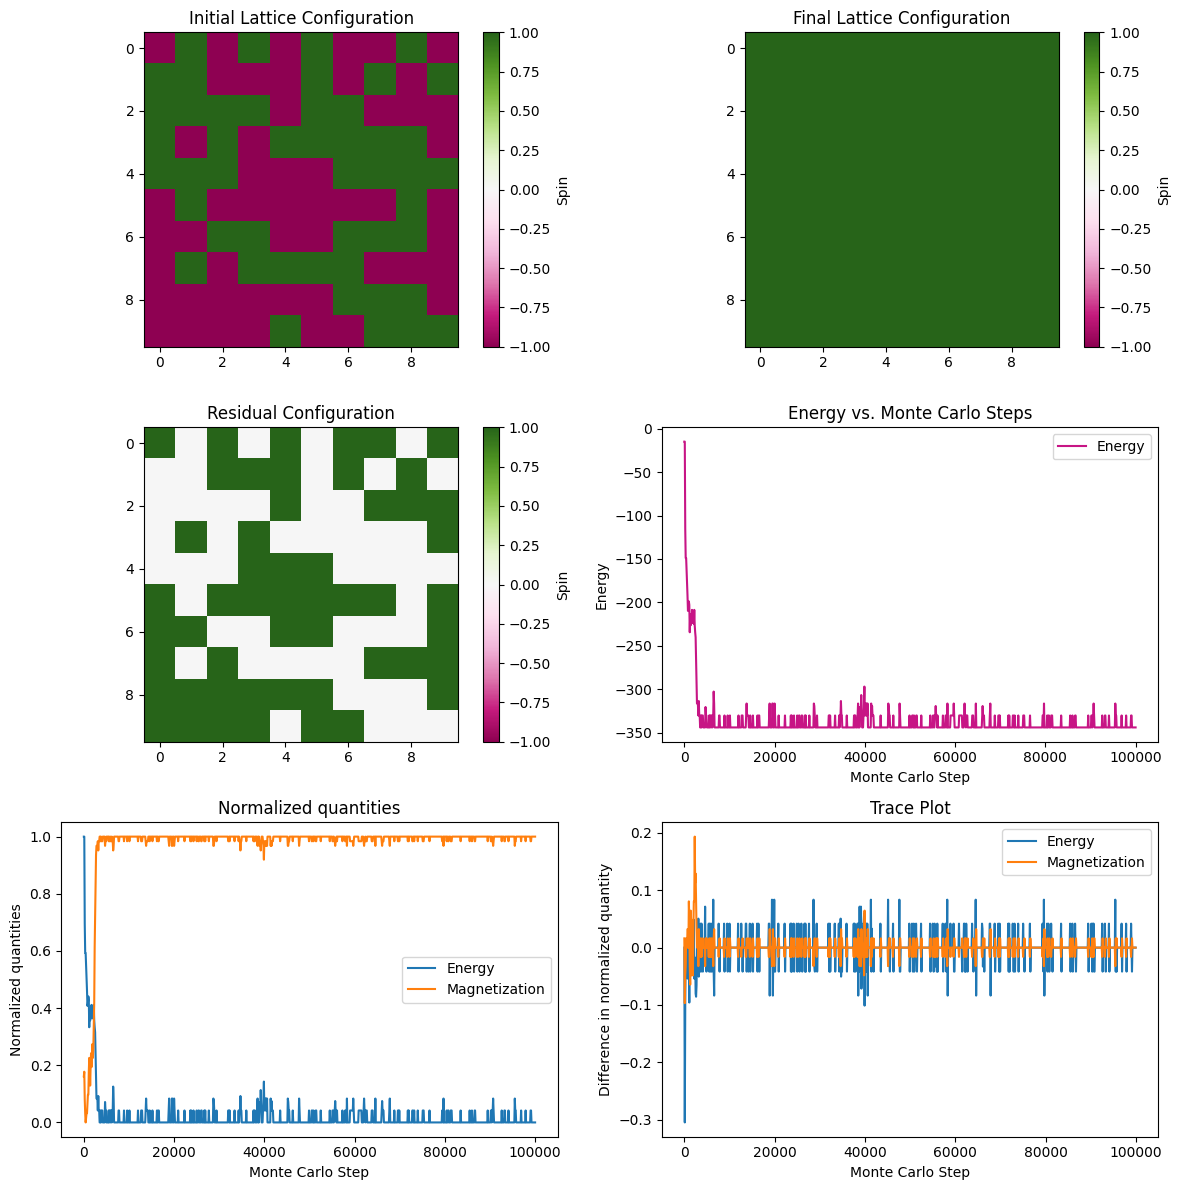

In [10]:
J = 1
J2 = 0.72
h = 0
L = 10
T = 2.26
beta = 1/T
steps = L**2*1000
spins_initial= initial_spins(L)
copy_of_spins_initial = spins_initial.copy()
final_spins, energy, mag_values= monte_carlo(beta, J, h, L, steps, copy_of_spins_initial, J2)


Visualization_of_MC(spins_initial, final_spins, energy, mag_values)

[np.float64(-0.0), np.float64(4.089353285267443), np.float64(8.178706570534885), np.float64(1.394879934574992), np.float64(16.35741314106977)]


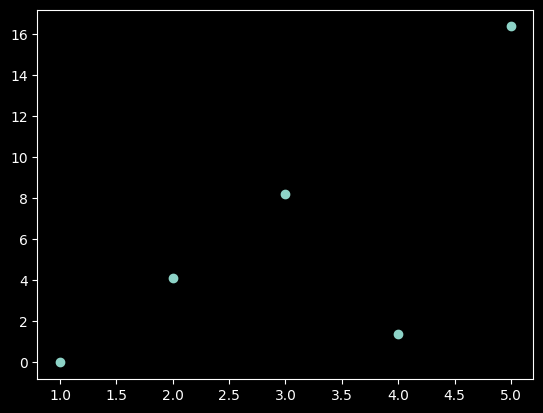

6.0040705862894175


In [11]:
temp = np.linspace(0.0001, 5, 150)
beta = []
for temp_value in temp:
    beta.append(1/temp_value)
J = 1
h = 0
L = 15
steps = L**2*1000


spins_initial = np.ones([L,L])

copy_of_spins_initial = spins_initial.copy()

magnetization_values, specific_heat_values, susceptibility_values, correlation_values = run_monte_carlo(beta, J, h, L, steps, copy_of_spins_initial)


/var/folders/jn/kf2wnj4j57v2sjyq4ywhqpj40000gn/T/ipykernel_58615/1981503633.py:211: RuntimeWarning: invalid value encountered in log
  denominator = np.log(spinspin[r]-m**2)


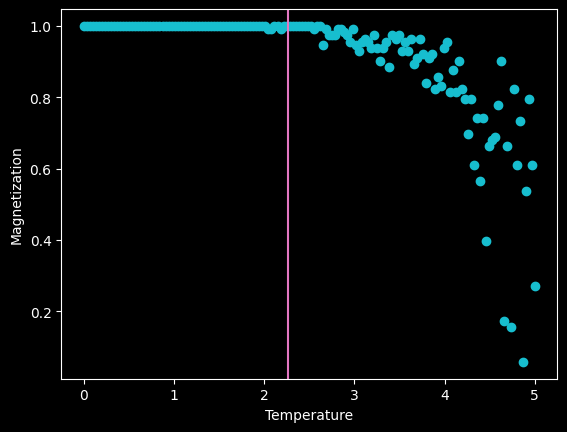

In [12]:
plt.style.use('dark_background')
plt.scatter(temp, np.abs(magnetization_values)/L**2, label="Monte Carlo Steps", color ='#17BECF')
plt.axvline(x=2.269, color='#E377C2')
plt.ylabel("Magnetization")
plt.xlabel("Temperature")
plt.show()

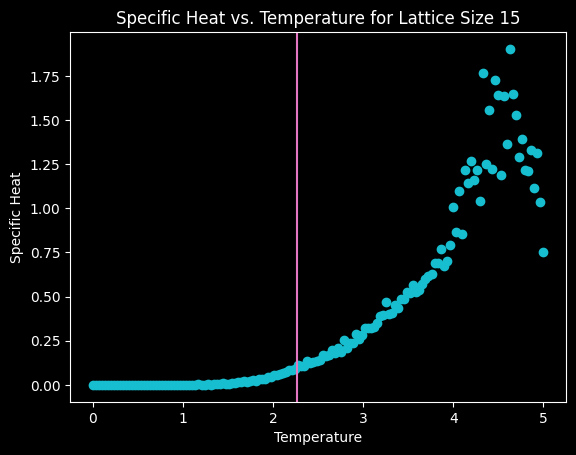

In [13]:
plt.scatter(temp, specific_heat_values, label="Monte Carlo Steps", color ='#17BECF')
#plt.semilogy()
plt.axvline(x=2.269, color='#E377C2')
plt.ylabel("Specific Heat")
plt.xlabel("Temperature")
plt.title("Specific Heat vs. Temperature for Lattice Size {}".format(L))
plt.rcParams['figure.facecolor'] = '#000000'
plt.show()

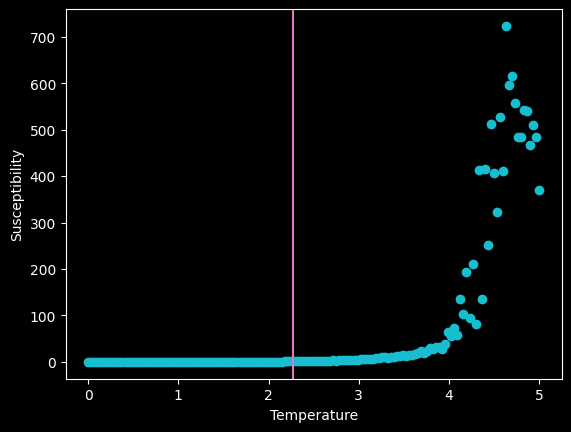

In [14]:
plt.scatter(temp, susceptibility_values, label="Monte Carlo Steps",  color ='#17BECF')
#plt.semilogy()
plt.axvline(x=2.269, color='#E377C2')
plt.ylabel("Susceptibility")
plt.xlabel("Temperature")
plt.show()


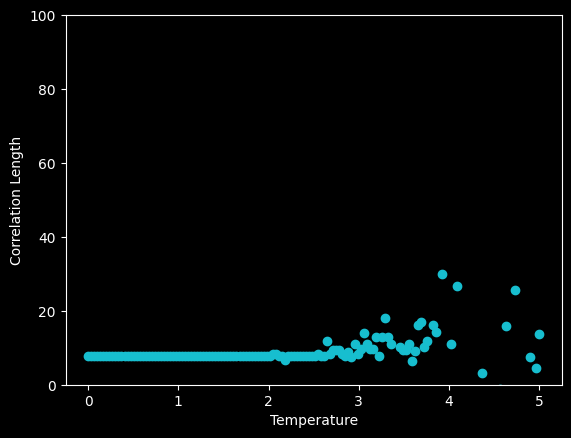

In [15]:
plt.scatter(temp, correlation_values, label="Monte Carlo Steps",  color ='#17BECF')
#plt.semilogy()
plt.ylim(0,100)
plt.ylabel("Correlation Length")
plt.xlabel("Temperature")
plt.show()


In [208]:
print("T_c is {} from susceptiblity".format(Tc_from_sus(susceptibility_values, temp)))
print("T_c is {} from specific heat".format(Tc_from_specific_heat(specific_heat_values, temp)))

T_c is 2.449715436241611 from susceptiblity
T_c is 2.248377181208054 from specific heat


In [16]:
temp = np.linspace(2, 6, 150)
beta = []
for temp_value in temp:
    beta.append(1/temp_value)
J = 1
h = 0
L_values = np.arange(35, 6, -7)

Heat_Capacity_L = []
Sus_L=[]
mag_L=[]
xi_L = []
sus_tot = []
heat_capacity_tot=[]
mag_tot = []
xi_tot = []
Tc_index = 0

for L in L_values:
    spins_initial = np.ones([L,L])
    steps = L**2 * 1000
    copy_of_spins_initial = spins_initial.copy()
    magnetization_values, specific_heat_values, susceptibility_values, xi_values = run_monte_carlo(beta, J, h, L, steps, copy_of_spins_initial)
    sus_tot.append(susceptibility_values)
    mag_tot.append(magnetization_values)
    heat_capacity_tot.append(specific_heat_values)
    xi_tot.append(xi_values)
    
    #finding values at Tc
    Tc_index = specific_heat_values.index(max(specific_heat_values))
    Heat_Capacity_L.append((specific_heat_values[Tc_index]))
    sus_value = susceptibility_values[Tc_index]
    sus_value = sus_value/(L**2)
    Sus_L.append(sus_value)
    mag_value = magnetization_values[Tc_index]
    mag_value = mag_value/(L**2)
    mag_L.append(mag_value)
    xi_value = xi_values[Tc_index]
    xi_L.append(xi_value)
    

       
'''if Tc_index == 0:
        Tc_index = specific_heat_values.index(max(specific_heat_values))
        Heat_Capacity_L.append((specific_heat_values[Tc_index]))
        sus_value = susceptibility_values[Tc_index]
        sus_value = sus_value/(L**2)
        Sus_L.append(sus_value)
        mag_value = magnetization_values[Tc_index]
        mag_value = mag_value/(L**2)
        mag_L.append(mag_value)
        beta = [beta[Tc_index]]
   
        else:
        Heat_Capacity_L.append((specific_heat_values[0]))
        sus_value = susceptibility_values[0]
        sus_value = sus_value/(L**2)
        Sus_L.append(sus_value)
        mag_value = magnetization_values[0]
        mag_value = mag_value/(L**2)
        mag_L.append(mag_value)
'''

/var/folders/jn/kf2wnj4j57v2sjyq4ywhqpj40000gn/T/ipykernel_58615/1981503633.py:211: RuntimeWarning: invalid value encountered in log
  denominator = np.log(spinspin[r]-m**2)
/var/folders/jn/kf2wnj4j57v2sjyq4ywhqpj40000gn/T/ipykernel_58615/1981503633.py:212: RuntimeWarning: divide by zero encountered in scalar divide
  xi[r]= -r/denominator


'if Tc_index == 0:\n        Tc_index = specific_heat_values.index(max(specific_heat_values))\n        Heat_Capacity_L.append((specific_heat_values[Tc_index]))\n        sus_value = susceptibility_values[Tc_index]\n        sus_value = sus_value/(L**2)\n        Sus_L.append(sus_value)\n        mag_value = magnetization_values[Tc_index]\n        mag_value = mag_value/(L**2)\n        mag_L.append(mag_value)\n        beta = [beta[Tc_index]]\n   \n        else:\n        Heat_Capacity_L.append((specific_heat_values[0]))\n        sus_value = susceptibility_values[0]\n        sus_value = sus_value/(L**2)\n        Sus_L.append(sus_value)\n        mag_value = magnetization_values[0]\n        mag_value = mag_value/(L**2)\n        mag_L.append(mag_value)\n'

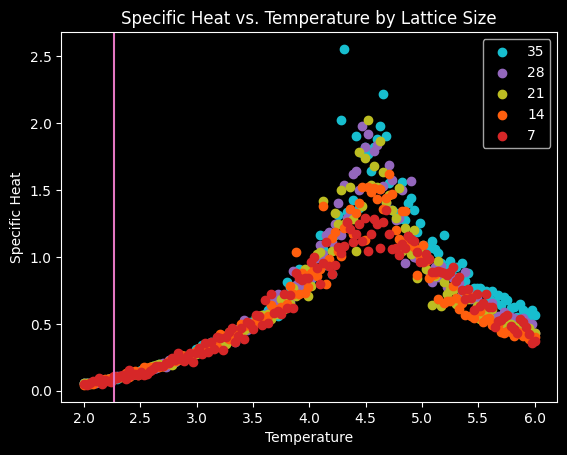

In [18]:
color_list = ['#17BECF', '#9467BD', '#BCBD22', '#FF5F0E', '#D62728', '#1F77B4']
for i in range(len(L_values)):
    plt.scatter(temp, heat_capacity_tot[i], color=color_list[i], label='{}'.format(L_values[i]))
plt.legend()
plt.axvline(x=2.269, color='#E377C2')
plt.ylabel("Specific Heat")
plt.xlabel("Temperature")
plt.title("Specific Heat vs. Temperature by Lattice Size")
plt.show()

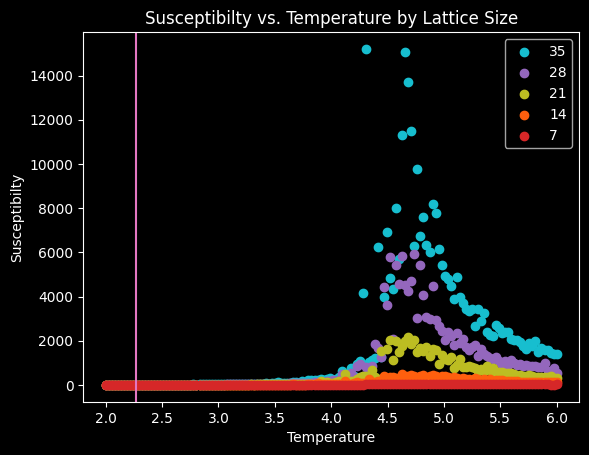

In [19]:
color_list = ['#17BECF', '#9467BD', '#BCBD22', '#FF5F0E', '#D62728', '#1F77B4']
for i in range(len(L_values)):
    plt.scatter(temp, sus_tot[i], color=color_list[i], label='{}'.format(L_values[i]))
plt.legend()
plt.axvline(x=2.269, color='#E377C2')
plt.ylabel("Susceptibilty")
plt.xlabel("Temperature")
plt.title("Susceptibilty vs. Temperature by Lattice Size")
plt.show()

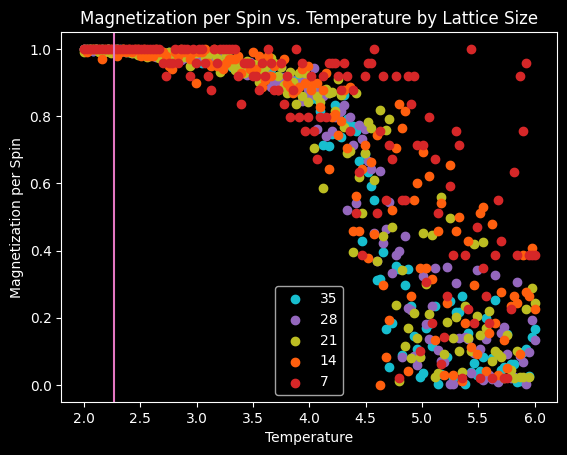

In [20]:
color_list = ['#17BECF', '#9467BD', '#BCBD22', '#FF5F0E', '#D62728', '#1F77B4']
mag_tot_per_L = []
for i in range(len(L_values)):
    m = mag_tot[i]/(L_values[i]**2)
    mag_tot_per_L.append(m)
for i in range(len(L_values)):
    plt.scatter(temp, np.abs(mag_tot_per_L[i]), color=color_list[i], label='{}'.format(L_values[i]))
plt.legend()
plt.axvline(x=2.269, color='#E377C2')
plt.ylabel("Magnetization per Spin")
plt.xlabel("Temperature")
plt.title("Magnetization per Spin vs. Temperature by Lattice Size")
plt.show()

[[np.float64(20.236846200038144), np.float64(20.481071102142987), np.float64(20.236846200038144), np.float64(20.72962798517814), np.float64(19.996838143239287), np.float64(20.481071102142987), np.float64(20.481071102142987), np.float64(20.720470613130317), np.float64(20.236846200038144), np.float64(20.481071102142987), np.float64(20.72962798517814), np.float64(20.236846200038144), np.float64(20.236846200038144), np.float64(20.481071102142987), np.float64(21.240219438752412), np.float64(20.83553797891383), np.float64(21.50250607836405), np.float64(19.540725534164935), np.float64(20.982636186233734), np.float64(21.769629260394172), np.float64(19.540725534164935), np.float64(21.497529509300147), np.float64(20.72962798517814), np.float64(21.769020679870177), np.float64(nan), np.float64(22.88933246617521), np.float64(22.31894336456945), np.float64(22.88933246617521), np.float64(21.50250607836405), np.float64(20.03087369578461), np.float64(22.041727189827654), np.float64(26.105478151005446),

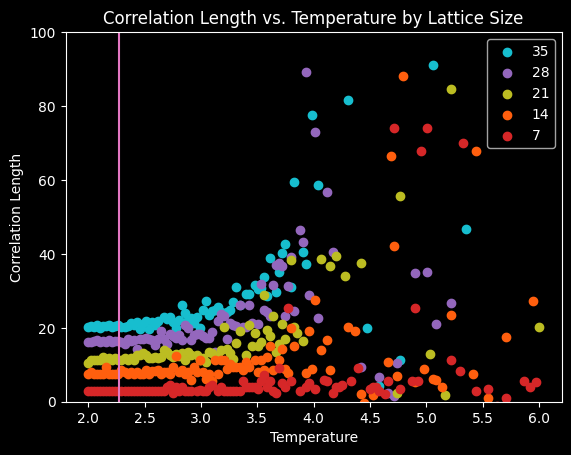

In [21]:
color_list = ['#17BECF', '#9467BD', '#BCBD22', '#FF5F0E', '#D62728', '#1F77B4']
print(xi_tot)
for i in range(len(L_values)):
    plt.scatter(temp, xi_tot[i], color=color_list[i], label='{}'.format(L_values[i]))
plt.legend()
plt.axvline(x=2.269, color='#E377C2')
plt.ylabel("Correlation Length")
plt.xlabel("Temperature")
plt.ylim(0,100)
plt.title("Correlation Length vs. Temperature by Lattice Size")
plt.show()

[np.float64(12.41123243146715), np.float64(5.6530883516893455), np.float64(4.63589867191942), np.float64(2.2335015022721803), np.float64(0.7344286132690894)]


/var/folders/jn/kf2wnj4j57v2sjyq4ywhqpj40000gn/T/ipykernel_58615/525224555.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(log_L, res.intercept + res.slope*log_L, 'r', label='Line of Best Fit: y = {:.2f}x + {:.2f}'.format(res.slope, res.intercept), color='#17BECF')
/var/folders/jn/kf2wnj4j57v2sjyq4ywhqpj40000gn/T/ipykernel_58615/525224555.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(log_L, -3.77 + 1.75 * log_L, 'r', label= 'Line of Expected Fit: y = {:.2f}x + {:.2f}'.format(1.75, -3.77), color = '#FF7F0E')


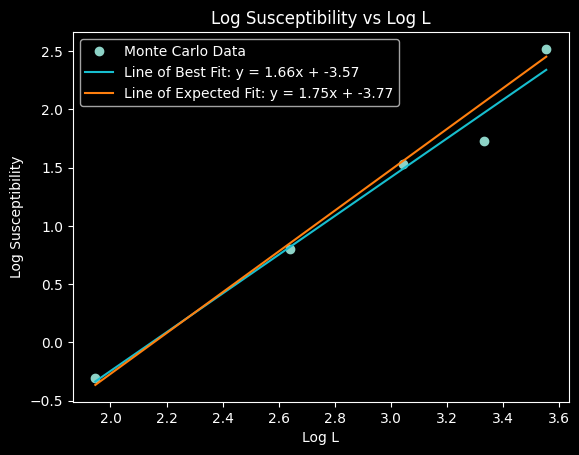

The graph is fit with the line y = 1.66160300125887x + -3.5684038666268565


In [31]:
print(Sus_L)
log_sus = np.log(Sus_L)
log_L = np.log(L_values)
res = stats.linregress(log_L, log_sus)
plt.plot(log_L, log_sus, 'o', label='Monte Carlo Data')
plt.plot(log_L, res.intercept + res.slope*log_L, 'r', label='Line of Best Fit: y = {:.2f}x + {:.2f}'.format(res.slope, res.intercept), color='#17BECF')
plt.plot(log_L, -3.77 + 1.75 * log_L, 'r', label= 'Line of Expected Fit: y = {:.2f}x + {:.2f}'.format(1.75, -3.77), color = '#FF7F0E')
plt.legend()
plt.title("Log Susceptibility vs Log L")
plt.ylabel('Log Susceptibility')
plt.xlabel("Log L")
plt.show()

print("The graph is fit with the line y = {}x + {}".format(res.slope, res.intercept))

/var/folders/jn/kf2wnj4j57v2sjyq4ywhqpj40000gn/T/ipykernel_58615/2831143956.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(log_L, res.intercept + res.slope*log_L, 'r', label='Line of Best Fit: y = {:.2f}x + {:.2f}'.format(res.slope, res.intercept), color='#17BECF')
/var/folders/jn/kf2wnj4j57v2sjyq4ywhqpj40000gn/T/ipykernel_58615/2831143956.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(log_L, 1.05 + -0.125 * log_L, 'r', label= 'Line of Expected Fit: y = {:.3f}x + {:.2f}'.format(-0.125, 1.05), color = '#FF7F0E')


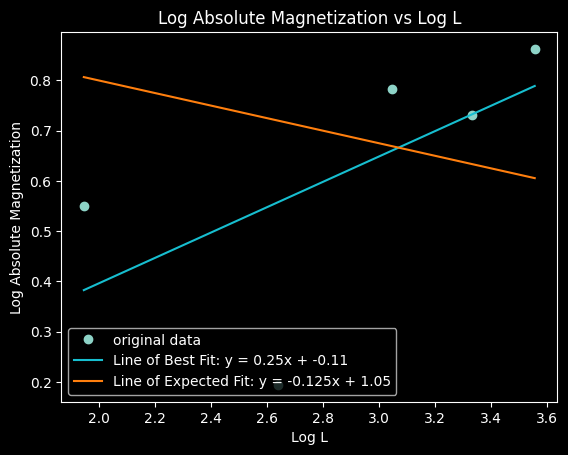

The graph is fit with the line y = 0.2525631693214057x + -0.10885187512076933


In [23]:
log_M = np.abs(mag_L)#np.log(np.abs(mag_L))
log_L = np.log(L_values)
res = stats.linregress(log_L, log_M)
plt.plot(log_L, log_M, 'o', label='original data')
plt.plot(log_L, res.intercept + res.slope*log_L, 'r', label='Line of Best Fit: y = {:.2f}x + {:.2f}'.format(res.slope, res.intercept), color='#17BECF')
plt.plot(log_L, 1.05 + -0.125 * log_L, 'r', label= 'Line of Expected Fit: y = {:.3f}x + {:.2f}'.format(-0.125, 1.05), color = '#FF7F0E')
plt.ylabel('Log Absolute Magnetization')
plt.xlabel("Log L")
plt.title("Log Absolute Magnetization vs Log L")
plt.legend()
plt.show()

print("The graph is fit with the line y = {}x + {}".format(res.slope, res.intercept))

/var/folders/jn/kf2wnj4j57v2sjyq4ywhqpj40000gn/T/ipykernel_58615/2830516214.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(log_L, res.intercept + res.slope*log_L, 'r', label='Line of Best Fit: y = {:.2f}x + {:.2f}'.format(res.slope, res.intercept), color='#17BECF')
/var/folders/jn/kf2wnj4j57v2sjyq4ywhqpj40000gn/T/ipykernel_58615/2830516214.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(log_L, 0.34+ 0.50 * log_L, 'r', label= 'Line of Expected Fit: y = {:.2f}x + {:.2f}'.format(0.500, 0.34), color = '#FF7F0E')


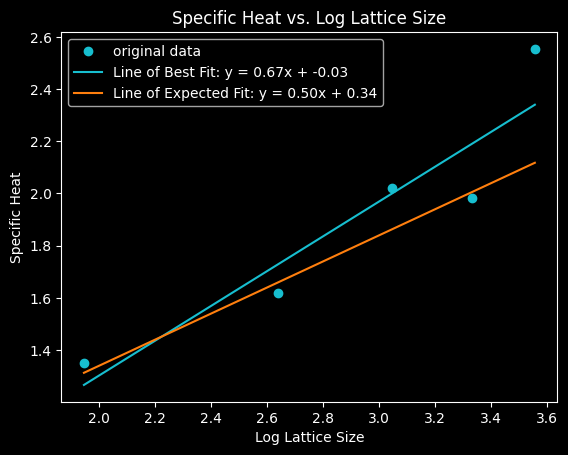

The graph is fit with the line y = 0.67x + -0.03


In [24]:
#log_HC = np.log(Heat_Capacity_L)
log_L = np.log(L_values)
res = stats.linregress(log_L, Heat_Capacity_L)
plt.plot(log_L, Heat_Capacity_L, 'o', label='original data', color='#17BECF')
plt.plot(log_L, res.intercept + res.slope*log_L, 'r', label='Line of Best Fit: y = {:.2f}x + {:.2f}'.format(res.slope, res.intercept), color='#17BECF')
plt.plot(log_L, 0.34+ 0.50 * log_L, 'r', label= 'Line of Expected Fit: y = {:.2f}x + {:.2f}'.format(0.500, 0.34), color = '#FF7F0E')
plt.ylabel('Specific Heat')
plt.xlabel("Log Lattice Size")
plt.title("Specific Heat vs. Log Lattice Size")
plt.legend()
plt.show()
print("The graph is fit with the line y = {:.2f}x + {:.2f}".format(res.slope, res.intercept))

/var/folders/jn/kf2wnj4j57v2sjyq4ywhqpj40000gn/T/ipykernel_58615/1068079525.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(log_L, res.intercept + res.slope*log_L, 'r', label='Line of Best Fit: y = {:.2f}x + {:.2f}'.format(res.slope, res.intercept), color='#17BECF')
/var/folders/jn/kf2wnj4j57v2sjyq4ywhqpj40000gn/T/ipykernel_58615/1068079525.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(log_L, 0.34+ 0.50 * log_L, 'r', label= 'Line of Expected Fit: y = {:.2f}x + {:.2f}'.format(0.500, 0.34), color = '#FF7F0E')


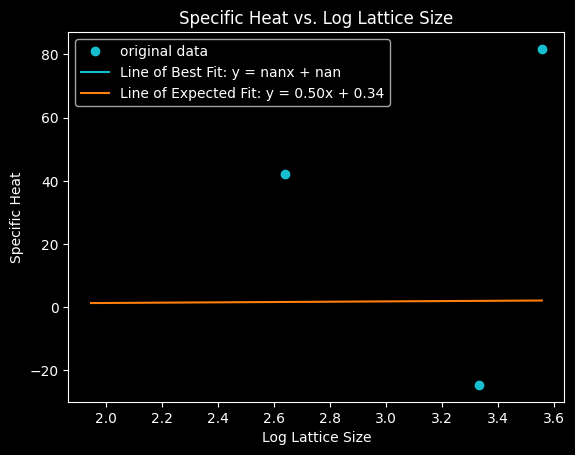

The graph is fit with the line y = nanx + nan


In [25]:
#log_HC = np.log(Heat_Capacity_L)
x = np.log(L_values)
y = xi_L
res = stats.linregress(x, y)
plt.plot(x, y, 'o', label='original data', color='#17BECF')
plt.plot(log_L, res.intercept + res.slope*log_L, 'r', label='Line of Best Fit: y = {:.2f}x + {:.2f}'.format(res.slope, res.intercept), color='#17BECF')
plt.plot(log_L, 0.34+ 0.50 * log_L, 'r', label= 'Line of Expected Fit: y = {:.2f}x + {:.2f}'.format(0.500, 0.34), color = '#FF7F0E')
plt.ylabel('Specific Heat')
plt.xlabel("Log Lattice Size")
plt.title("Specific Heat vs. Log Lattice Size")
plt.legend()
plt.show()
print("The graph is fit with the line y = {:.2f}x + {:.2f}".format(res.slope, res.intercept))